In [233]:
# structure de données
import pandas as pd
import numpy as np
from collections import Counter

# Traitement de texte
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# graphique
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [234]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# A. Importation des données

##### Fichiers csv provenant de l'extraction SQL de StackOverFlow. Seule une partie de la table "posts" a été récupérée. Les questions ont été sélectionnées en fonction : 
- de leur score
- de leur nombre de vues
- du nombre de réponses
- de nombre de commentaires
- du nombre de personnes l'ayant mise en favori

In [235]:
train = pd.read_csv("train.csv", sep=',', header=0)
test = pd.read_csv('test.csv', sep=',', header=0)

In [236]:
print("La table d'entrainement a {} posts et {} variables".format(
    train.shape[0], train.shape[1]))
train.head()

La table d'entrainement a 204432 posts et 9 variables


,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,26477388,23,5693.0,<p>In SBT is the use of <em>aggregate</em> fol...,Is the use of 'aggregate' following by 'depend...,<build><sbt>,1.0,0,9.0
1,20580028,22,37747.0,"<p>I'm designed a <a href=""http://en.wikipedia...","Flowchart ""for each"" loop loop without variabl...",<flowchart>,5.0,1,2.0
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0
4,2036744,27,21402.0,<p>I have to write some code in ML and it is m...,ML IDE and Compiler for Windows or Linux or Mac,<ide><compiler-construction><programming-langu...,6.0,0,17.0


In [237]:
print("La table de test a {} posts et {} variables".format(
    test.shape[0], test.shape[1]))
test.head()

La table de test a 51109 posts et 9 variables


,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,14964108,26,32507.0,<p>I'm currently trying to build a little test...,Alternative to PhantomJS for Testing,<javascript><testing><phantomjs>,4.0,1,7.0
1,7439273,26,18913.0,<p>I am handling touches for a couple of my UI...,"UIScrollView prevents touchesBegan, touchesMov...",<iphone><uiscrollview><touch><viewcontroller><...,5.0,1,8.0
2,29382728,26,14626.0,<p>I just read somewhere that having an interf...,Constant Interface Anti-Pattern Clarification,<java>,4.0,2,3.0
3,13883404,26,68725.0,<p>I'm interested in a PowerShell script that ...,Custom RoboCopy Progress Bar in PowerShell,<powershell>,7.0,2,20.0
4,27241881,26,20075.0,<p>I am trying to rename the class name in swi...,How to rename the class name in swift?,<ios><swift>,7.0,6,3.0


In [238]:
def hist_plot(df, var, name, nb_bins=50):
    df[var].hist(density=True, bins=nb_bins)
    plt.xlabel(var)
    plt.ylabel('Densité')
    plt.title('Distribution de {} \npour un échantillon de {} individus sur le jeu de {}'.format(
        var, df.shape[0], name))

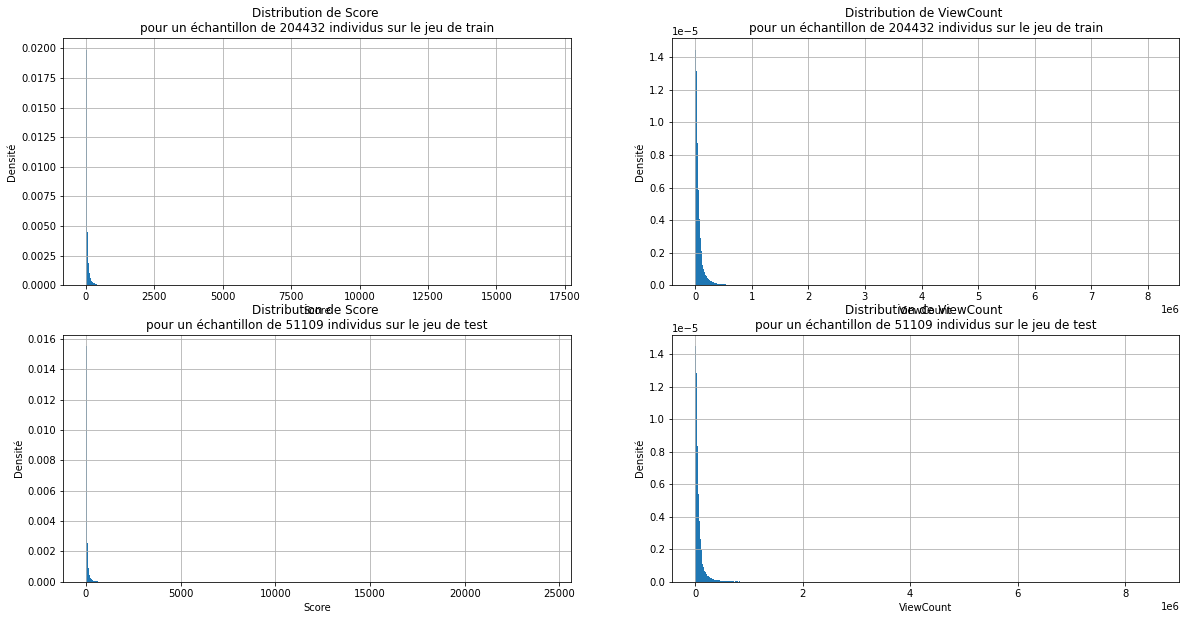

In [239]:
# Score des questions
plt.figure(figsize=(20, 10))
plt.subplot(221)
hist_plot(train, 'Score','train', 500)
plt.subplot(222)
hist_plot(train, 'ViewCount', 'train', 500)
plt.subplot(223)
hist_plot(test, 'Score','test', 500)
plt.subplot(224)
hist_plot(test, 'ViewCount', 'test', 500)

##### Après analyse on se rend compte que les jeux de données sont encore trop conséquents pour les performances de notre PC, on va donc les réduire en filtrant par rapport au score.

In [240]:
train = train[train['Score'] > 125]
print('La table de train a maintenant {} posts'.format(train.shape[0]))

La table de train a maintenant 23215 posts


In [241]:
test = test[test['Score'] > 125]
print('La table de test a maintenant {} posts'.format(test.shape[0]))

La table de test a maintenant 5570 posts


In [242]:
train = train.drop(columns=['Id', 'Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount'])
test = test.drop(columns=['Id', 'Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount'])

##### Maintenant que les jeux de données sont réduits, seul le texte et les tags nous intéressent, on peut passer aux prétraitements.

# B. Nettoyage des tables

## B.1. Variables de prédiction

### B.1.a. Extraction des labels à partir de tags

##### Il est nécessaire de remettre en forme les tags pour les analyser, on supprime les balises < et > les entourant

In [243]:
def extract_label(serie):
    return [', '.join(map(str, re.findall(r'\<(.*?)\>', x))) for x in serie]

### B.1.b. Suppression labels avec faible occurence

##### Afin de réduire le nombre de classes on fusionne certaines d'entre elles, notamment celles où seul le numéro de version diffère (ex : python et python 1.6.0)

In [244]:
# merge labels
def get_general_label(label):
    if 'python' in label:
        return 'python'
    elif 'c++' in label:
        return 'c++'
    elif 'asp.net' in label:
        return 'asp.net'
    elif 'ruby-on-rails' in label:
        return 'ruby-on-rails'
    elif 'visual-studio' in label:
        return 'visual-studio'
    elif 'javascript' in label:
        return 'javascript'
    elif 'java' in label:
        return 'java'
    elif 'angular' in label:
        return 'angular'
    elif 'android_studio' in label:
        return 'android-studio'
    elif 'android' in label:
        return 'android'
    else:
        return label

##### On se fixe un seuil minimal d'occurence et on récupère l'ensemble des tags supérieur à ce seuil. Ceci afin de réduire le nombre de tags et améliorer nos performances même si on perd en précision et en variété de tags

In [245]:
def get_most_frequent_label(series, threshold=5):
    # récupération de tous les labels
    list_labels = [get_general_label(j) for i in series for j in i.split(", ")]

    # On conserve les labels dont la fréquence d'apparition est > threshold
    freq = pd.Series(list_labels).value_counts()
    print(freq)
    clean_list_labels = freq[freq >= threshold]
    print('{} tags sur {} ont été conservés'.format(
        clean_list_labels.shape[0], freq.shape[0]))

    return clean_list_labels

##### Une fois la liste de tags réduite récupérée, on filtre les deux jeux de données avec celle-ci. Il faut faire attention à supprimer les posts qui n'auraient plus aucun tag existant et à fusionner les tags doublons

In [246]:
def filter_labels(dataset, label_column, clean_list_labels):
    df = dataset.copy()
    # application au dataset
    df[label_column] = [', '.join(map(str, [get_general_label(y) for y in x.split(
        ", ") if y in clean_list_labels.index])) for x in df[label_column]]
    # suppression doublons apres fusion
    df[label_column] = [', '.join(set(i.split(", ")))
                        for i in df[label_column]]

    # suppression des posts sans label du dataset
    clean_df = df[df[label_column] != '']
    print('La table est passée de {} posts à {} posts après suppression des posts sans tags'.format(
        df.shape[0], clean_df.shape[0]))

    return clean_df

In [247]:
# Extraction des labels
train['Labels'] = extract_label(train['Tags'])
test['Labels'] = extract_label(test['Tags'])

# Filtrage sur tags les plus fréquents du jeu d'entrainement
clean_list_labels = get_most_frequent_label(train['Labels'], 100)
clean_train = filter_labels(train, 'Labels', clean_list_labels)
clean_test = filter_labels(test, 'Labels', clean_list_labels)

android        2821
python         2753
javascript     2582
java           2323
c#             1732
               ... 
base-url          1
cpanel            1
exponentjs        1
caanimation       1
                  1
Length: 6401, dtype: int64
86 tags sur 6401 ont été conservés
La table est passée de 23215 posts à 20807 posts après suppression des posts sans tags
La table est passée de 5570 posts à 4992 posts après suppression des posts sans tags


##### Malgré que le problème soit à l'origine un problème multilabels. On ne va conserver qu'un seul label par question pour des questions de performance, on va donc passer à un problème unilabel. 

##### En effet, dans le cadre multilabel on serait parti :
- soit sur un algorithme de Deep learning bien trop lourd pour nos capactiés actuelles
- soit sur un algorithme One Versus the Rest où un modèle binaire est créée pour chaque tag. Dans ce cas soit on aurait du réduire drastiquement le nombre de tags (déjà fortement réduits), soit on explose nos capacités.

Aucune de ces solutions n'étant envisageables, on passe en unilabel

In [248]:
# conservation un tag par question pour question de performances/puissance
clean_train['Label'] = [x.split(', ')[0] for x in clean_train["Labels"]]
clean_test['Label'] = [x.split(', ')[0] for x in clean_test["Labels"]]

##### On s'assure encore une fois qu'aucun post sans tag ne reste dans nos datasets

In [249]:
# suppression question du jeu de test qui ont un tag non existant dans jeu de train
# Filtrage sur tags les plus fréquents du jeu d'entrainement
clean_list_labels = get_most_frequent_label(clean_train['Label'])
clean_train = filter_labels(clean_train, 'Label', clean_list_labels)
clean_test = filter_labels(clean_test, 'Label', clean_list_labels)

java         2059
python       1533
android      1291
git           972
html          955
             ... 
spring         17
forms          14
exception      13
tsql            6
dataframe       1
Length: 86, dtype: int64
85 tags sur 86 ont été conservés
La table est passée de 20807 posts à 20806 posts après suppression des posts sans tags
La table est passée de 4992 posts à 4991 posts après suppression des posts sans tags


In [250]:
clean_train.head()

,Body,Title,Tags,Labels,Label
20,<p>Bearing in mind that I'll be performing cal...,What is the ideal data type to use when storin...,<mysql><database-design><maps><mapping><latitu...,mysql,mysql
22,"<p>In Xcode 3, the line number of the current ...",Where do I find the line number in the Xcode e...,<xcode>,xcode,xcode
40,<p>I have a bitmap taken of a Base64 String fr...,How to Resize a Bitmap in Android?,<android><bitmap><base64>,android,android
48,<p>I'm working on networking for my app. So I ...,When should one use RxJava Observable and when...,<android><retrofit><rx-java>,android,android
51,<p>I am trying to calculate the height of a UI...,Figure out size of UILabel based on String in ...,<ios><iphone><string><swift3><uilabel>,"ios, string, iphone",ios


## B.2. Variables d'entrée texte

##### Voici ci dessous un exemple de texte sur lequel effectuer nos traitements

In [251]:
clean_train.loc[20, 'Body']

"<p>Bearing in mind that I'll be performing calculations on lat / long pairs, what datatype is best suited for use with a MySQL database?</p>\n"

### B.2.a. Suppression balises HTML

##### On commence par supprimer les balises HTML qui formatent notre texte.

In [252]:
def del_html(serie):
    basic_regex = '[ \n\r\t]'
    clean_serie = [re.sub(basic_regex, " ", x) for x in serie]
    return [BeautifulSoup(x, 'html.parser').get_text() for x in clean_serie]

### B.2.c. Concaténation titre et body

In [253]:
def get_full_text(dataset, text1, text2):
    return [str(x) + ' ' + y for x, y in zip(dataset[text1], dataset[text2])]

In [254]:
#clean_train['Clean_body'] = del_code(clean_train['Body'])
clean_train['Clean_body'] = del_html(clean_train['Body'])
clean_train['Text'] = get_full_text(clean_train, 'Title', 'Clean_body')

#clean_test['Clean_body'] = del_code(clean_test['Body'])
clean_test['Clean_body'] = del_html(clean_test['Body'])
clean_test['Text'] = get_full_text(clean_test, 'Title', 'Clean_body')

##### Voici le même texte que précédemment après concaténation avec son titre et nettoyage des balises HTML 

In [255]:
clean_train.loc[20, 'Text']

"What is the ideal data type to use when storing latitude / longitude in a MySQL database? Bearing in mind that I'll be performing calculations on lat / long pairs, what datatype is best suited for use with a MySQL database? "

### B.2.d. Tokenisation / Lemmatisation / Stop words

##### Maintenant on passe aux étapes de tokenisation, normalisation et filtrage de notre corpus

In [256]:
wnLemma = nltk.stem.WordNetLemmatizer()

In [257]:
def tokenize(serie_text, stop_words):
    # Tokenization
    # Remplacement négation 'nt par not
    tokens_serie = [text.replace("n't", " not") for text in serie_text]
    # passage en minuscule 
    tokens_serie = [[t.lower() for t in nltk.word_tokenize(
        text)] for text in tokens_serie]
    #Suppression de la ponctuation et caractères numériques
    pattern = '[^a-z.+-]+' # on garde + . et - pour les motys type 'my-sql', '.net', 'c++'
    tokens_serie = [[re.sub(pattern, '', t) for t in tokens if re.sub(pattern, '', t) != ''] for tokens in tokens_serie]  
    # lemmatisation et Suppression des stopwords
    tokens_serie = [[wnLemma.lemmatize(
        t) for t in tokens if t not in stop_words] for tokens in tokens_serie]
    return tokens_serie

In [258]:
def text_from_tokens(serie_tokens):
    serie_text = [' '.join([y for y in x])for x in serie_tokens]
    return serie_text

In [259]:
# Récupération des stop words anglais
try:
    stopwords = nltk.corpus.stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')

#Lemmatisation des stopwords pour rester cohérent
lemma_stopwords = [wnLemma.lemmatize(y) for y in stopwords]
#Ajout des stopwords lemmatisés et à la ponctuation restante indésirable à notre liste initale
stopwords = set(stopwords + lemma_stopwords + ['.', '', '-', '...', '--', '..', '+'])

In [260]:
list(stopwords)[:10]

['', 'have', "isn't", 'where', 'out', '+', 'there', "aren't", 'other', 've']

In [ ]:
clean_train['Tokens'] = tokenize(clean_train['Text'], stopwords)
clean_test['Tokens'] = tokenize(clean_test['Text'], stopwords)

In [ ]:
clean_train.head()

##### Voici le texte précécent après les prétraitements (sous forme de tokens)

In [ ]:
clean_train.loc[20, 'Tokens']

### B.2.e. Suppression mots avec faible occurence

##### Pour limiter la complexité et améliorer nos performances on réduit de même que pour les tags, le nombre de mots qui va être analysés. On se fixe alors un seuil d'occurence minimal

In [ ]:
def get_most_frequent_words(series, threshold=100):
    # récupération de tous les labels
    list_words = [j for i in series for j in i]

    # On conserve les labels dont la fréquence d'apparition est > threshold
    freq = pd.Series(list_words).value_counts()
    print(freq)
    clean_list_words = freq[freq > threshold]
    print('{} mots sur {} ont été conservés'.format(
        clean_list_words.shape[0], freq.shape[0]))

    return clean_list_words

##### On applique la liste de mots réduites à nos deux jeux de données

In [ ]:
def filter_words(dataset, tokens_column, clean_list_words):
    df = dataset.copy()
    # application au dataset
    df[tokens_column] = [[y for y in x if y in clean_list_words.index]
                         for x in df[tokens_column]]

    # Application au texte
    df['Text'] = text_from_tokens(df[tokens_column])
    df['Text'] = text_from_tokens(df[tokens_column])

    # suppression des posts sans texte du dataset
    clean_df = df[df['Text'] != '']
    print('La table est passée de {} posts à {} posts après suppression des posts sans texte'.format(
        df.shape[0], clean_df.shape[0]))

    return clean_df

##### On vérifie aussi qu'aucun post ne se retrouve sans texte

In [ ]:
# Filtrage sur tokens les plus fréquents du jeu d'entrainement
clean_list_words = get_most_frequent_words(clean_train['Tokens'], 150)
clean_train_2 = filter_words(clean_train, 'Tokens', clean_list_words)
clean_test_2 = filter_words(clean_test, 'Tokens', clean_list_words)

In [ ]:
final_train = clean_train_2.drop(columns=['Body', 'Title', 'Tags', 'Clean_body'])
final_test = clean_test_2.drop(columns=['Body', 'Title', 'Tags', 'Clean_body'])

In [ ]:
print(final_train.shape)
final_train.head()

# C. Exploration

## C.1. Labels

In [ ]:
all_clean_labels = [i for i in final_train['Label']]
freq = pd.Series(all_clean_labels).value_counts()

In [ ]:
plt.figure(figsize=(30, 5))
plt.xlabel('Labels')
plt.ylabel('Densité')
freq.plot(kind='bar', title='Les tags les plus fréquents par occurence')
plt.savefig('frequent_tags.png', bbox_inches='tight')

In [ ]:
print('{} tags différents existent'.format(freq.shape[0]))

## C.2 Mots

In [ ]:
all_words = [j for i in final_train['Tokens'] for j in i if j != '']
c = Counter(all_words)
k, v = zip(*c.most_common())

In [ ]:
plt.figure(figsize=(30, 5))
plt.xlabel('Mots')
plt.ylabel('Effectifs')
plt.xticks(rotation=90)
plt.xlim(-0.5, 99.5)
plt.title('Les 100 mots les plus fréquents par occurence')
plt.bar(k[:100], v[:100])
plt.savefig('frequent_words.png', bbox_inches='tight')

In [ ]:
print('{} mots différents existent'.format(len(k)))

In [ ]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(c)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud_words.png', bbox_inches='tight')

# D. Export des données

In [ ]:
print('Le jeu d\'entrainement contient finalement {} documents'.format(final_train.shape[0]))
print('Le jeu de test contient finalement {} documents'.format(final_test.shape[0]))
final_train.head()

In [ ]:
print('{} tags différents existent dans le jeu d\'entrainement'.format(len(set(final_train['Label']))))
print('{} tags différents existent dans le jeu de test'.format(len(set(final_test['Label']))))

In [ ]:
final_train.to_csv('clean_train.csv', index=False)
final_test.to_csv('clean_test.csv', index=False)